##### Load modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold

##### Load data

In [3]:
df = pd.read_pickle('train.pickle')
X = df.drop(columns='meter_reading')
y = df.meter_reading

##### Train models with 5-Fold cross validation

In [4]:
cv = KFold(4)
scores = {'estimator': [], 'train_score': [], 'test_score': []}
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'bagging_fraction': 0.1,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'learning_rate': 0.2,
    'lambda_l1': 1,
    'lambda_l2': 1
}

for train, valid in cv.split(X, y):
    gc.collect()
    
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_valid, y_valid = X.iloc[valid], y.iloc[valid]
    
    train = lgb.Dataset(X_train, y_train)
    valid = lgb.Dataset(X_valid, y_valid)
    
    estimator = lgb.train(
        params=params,
        train_set=train,
        valid_sets=(train, valid),
        num_boost_round=1000,
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    scores['estimator'].append(estimator)
    scores['train_score'].append(estimator.best_score['training']['rmse'])
    scores['test_score'].append(estimator.best_score['valid_1']['rmse'])
    
    print()

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 1.14708	valid_1's rmse: 1.25888
[200]	training's rmse: 1.02636	valid_1's rmse: 1.1965
[300]	training's rmse: 0.964903	valid_1's rmse: 1.17245
[400]	training's rmse: 0.920815	valid_1's rmse: 1.15561
[500]	training's rmse: 0.886646	valid_1's rmse: 1.14633
[600]	training's rmse: 0.862113	valid_1's rmse: 1.13676
[700]	training's rmse: 0.841282	valid_1's rmse: 1.13103
Early stopping, best iteration is:
[728]	training's rmse: 0.836565	valid_1's rmse: 1.12979

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 1.1548	valid_1's rmse: 1.27625
[200]	training's rmse: 1.0359	valid_1's rmse: 1.19199
[300]	training's rmse: 0.969908	valid_1's rmse: 1.15523
[400]	training's rmse: 0.925289	valid_1's rmse: 1.13166
[500]	training's rmse: 0.892754	valid_1's rmse: 1.11668
[600]	training's rmse: 0.86801	valid_1's rmse: 1.10687
[700]	training's rmse: 0.849358	valid_1's rmse: 1.10074
[800]	tr

train_score    0.834778
test_score     1.138199
dtype: float64


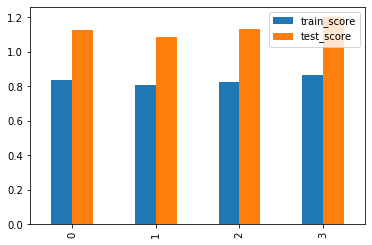

In [5]:
cols = ['train_score', 'test_score']
scores = pd.DataFrame(scores)
scores[cols] = scores[cols]
scores[cols].plot(kind='bar')
print(scores[cols].mean())

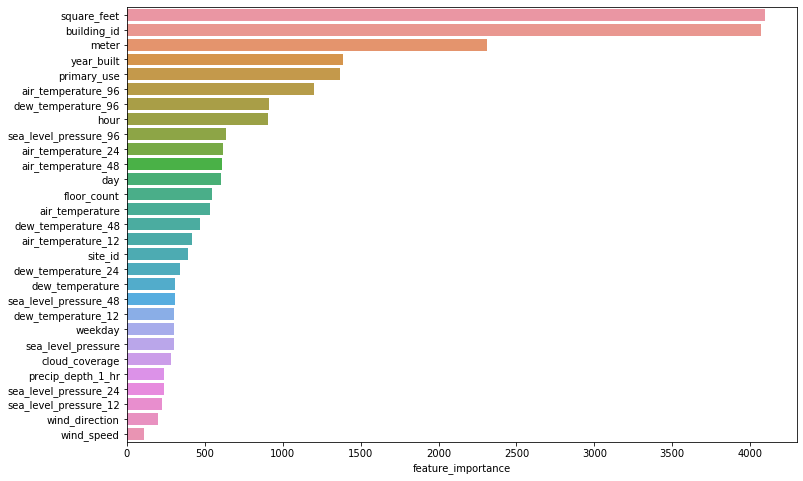

In [6]:
feature_importances = [model.feature_importance() for model in scores['estimator']]
feature_importances = np.mean(feature_importances, axis=0)
feature_importances = pd.DataFrame(data=feature_importances, index=X.columns, columns=['feature_importance'])
feature_importances.sort_values('feature_importance', ascending=False, inplace=True)

plt.figure(figsize=[12, 8])
sns.barplot(x=feature_importances.feature_importance, y=feature_importances.index, orient='h')
plt.show()

In [7]:
for idx, model in enumerate(scores['estimator']):
    model.save_model('{}.model'.format(idx))